In [2]:
import numpy as np
import sympy as sp
import sklearn as sk
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model    import Perceptron ,  LogisticRegression
from sklearn.metrics         import precision_recall_fscore_support
from sklearn.svm             import LinearSVC, SVC
from sklearn.utils           import shuffle
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D


import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import learning_curve

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

import csv
seed = 42

# Funciones Auxiliares

In [3]:
#########################################################################
######################## LECTURA DE DATOS ###############################
#########################################################################

def read_data():
    """
    Función para leer los datos
    """
    directorio = 'datos/'
    file       = 'bank-full.csv'
    file2      = 'bank.csv'

    path       = directorio + file
    path2      = directorio + file2
    
    # Leemos los dos ficheros y lo metemos en un dataframe de pandas

    df1  = pd.read_csv(path,delimiter=";",na_values = 'unknown')
    df2  = pd.read_csv(path2,delimiter=";",na_values = 'unknown')

    df   = pd.concat([df1, df2],ignore_index=True,axis=0)

    # Obtenemos el nombre de las características
    features = df.columns.to_list()
    features
    # Cambiamos las etiquetas a valores numericos
    df['y'].replace(to_replace='no', value=-1, inplace=True)
    df['y'].replace(to_replace='yes', value=1, inplace=True)
    
    return df, features


#########################################################################
############################ PREPROCESADO ###############################
#########################################################################

def search_cols_encoders(dftrain):
    """
    Función para buscar las variables categoóricas que son aquellas que son de tipo 'object'
    
    Params:
    --------
    - dftrain: pd.Dataframe
        Conjunto de datos en formato pandas
        
    Return:
    ----------
        - cols_encoder: diccionario con las columnas a codificar 
    """
    # Obtenemos el nombre de las características en un vector
    features = dftrain.columns.to_list()[:-1]

    # Calculamos un diccionario con clave, la posición de la característica categórica en el vector de 
    # características y como valor el nombre de dicha caracteristica
    cols_encoder = {}
    for i,col in enumerate(dftrain.columns):
        if dftrain[col].dtype == 'object':
            cols_encoder[i] = col
    cols_encoder
    
    return cols_encoder


def dependencia(X,y,umbral):
    """
    Función que estudia la información Mutua para ver la dependencia.
    Guardamos los mejores atributos en un array que son los que tienen una dependencia mayor al umbral.
    
    Return:
    ----------
    - m: list de tuplas atributo-información
    - best: aquellos atributos que superen el umbral
    """
    m = list(enumerate(mutual_info_classif(X, y, discrete_features='auto', n_neighbors=5, copy=True, random_state=seed)))
    best = []

    for i, info in m:
        if info > umbral:
            best.append(i)
    return m, np.asarray(best)


def one_hot_encoder_pandas(dftrain,dftest,cols_encoder,training_only = False):
    """
    Función que realiza el one hot encoding sobre un dataframe de pandas.
    
    Nota:
    ----------
    No devuelve nada, modifica los dos primeros argumentos
    
    
    Params:
    ----------
        - dftrain: pandas.DataFrame
            Dataframe con los datos de entrenamiento
        - dftest; pandas.DataFrame
            Dataframe con los datos de test
        - cols_encoders: dict (ncolumn,name)
            Diccionario que contiene las columnas a las cuales le queremos
            aplicar el one hot encoding
                Clave: ncolumn, int
                    Indice de la columna
                Valor: name, string
                    Nombre de la columna
                    
    Return:
    ----------
        Nada, las modificaciones se hacen inplace sobre los argumentos
    """

    onehot = {}

    # Recorremos todas las características
    for col in features:
        # Pero nos quedamos en las categóricas
        if col in cols_encoder.values():

            ####### TRAINING
            # Declaramos la instancia del one hot encoding 
            onehot[col] = OneHotEncoder(handle_unknown = 'ignore')
            # Entrenamos la instancia con los datos de la columna
            # El argumento tiene que ser un array de numpy
            # Hacemos reshape para que tenga dimension [instancias,1]
            onehot[col].fit(dftrain[col].to_numpy().reshape(-1,1))
            # Obtenemos la matriz con las codificaciones
            # La transformacino debe de ser tambien un array de numpy
            # Pasmos los datos a array
            aux = onehot[col].transform(dftrain[col].to_numpy().reshape(-1,1)).toarray()
            

            # Añadimos cada columna del nuevo dataframe a nuestro dataframe original
            for i in range(aux.shape[1]):
                dftrain[col+str(i)] = aux[:,i]
            # Borramos de nuestro dataframe la columna la cual hemos vectorizado ya que no sirve 
            dftrain.drop([col],axis=1,inplace=True)

            if training_only==False:
                ####### TEST
                aux = onehot[col].transform(dftest[col].to_numpy().reshape(-1,1)).toarray()


                for i in range(aux.shape[1]):
                    dftest[col+str(i)] = aux[:,i]

                dftest.drop([col],axis=1,inplace=True)
            

def normalizar_zscore(df_train,df_test,features,training_only=False):
    """
    Normalizar df_train a con media 0 y varianza 1 y usa los mismos datos
    para normalizar el conjunto de test.
    
    Return:
    ---------
        - Vector con la media de cada columna
        - Vector con la desviación típica de cada columna
        Modifica los argumentos in place
    """
    vmean = []
    vstd  = []

    for col in features:
        mean = df_train[col].mean()
        std  = df_train[col].std(ddof=0)
        
        vmean.append(mean)
        vstd.append(std)
        
        df_train[col] = (df_train[col] - mean) / std
        if training_only == False:
            df_test[col]  = (df_test[col] - mean) / std

    return vmean, vstd
        
def search_numeric_ft(dftrain):
    """
    Busca las variables que son de tipo numérico y las devuelve
    """
    numeric_features = []
    for col in dftrain.columns:
        if dftrain[col].dtype != 'object':
            numeric_features.append(col)

    numeric_features = numeric_features[0:7]
    
    return numeric_features
    
def desnormalizar(dftrain,dftest,features, mean, std, training_only = False):
    """
    Esta función se aplica a los datos de entrenamiento y test que previamente se han normalizado
    para restaurar sus valores originales
    
    Params:
    ----------
        - mean: media que se ha usdo para normalizra
        - std: desviación tipica usada para normalizar
        
    Return:
    ----------
        No devuelve nada, las modificaciones se hacen in-place
    """
    
    for i, col in enumerate(features):
        
        dftrain[col] = dftrain[col]*std[i] + mean[i]
        if training_only == False:
            dftest[col]  = dftest[col]*std[i] + mean[i]
        
        
def input_missing_values(dftrain,dftest,ft_missing_v,training_only = False):
    """
    Imputa valores perdidos tanto en el conjunto de entrenamiento como el de test.
    La imputación del conjunto de test se realizará con los parámetros obtenidos en el conjunto de training
    
    Params:
    ----------
        - dftrain/dftest: pd.DataFrame
            Conjuntos de train y test
        - fg_missing_v: list/np.ndarray:
            Atributos a los cuales le vamos a hacer la imputación.
        - training_only: bool, default=False
            Variable que indica si solo se aplica al conjunto de entrenamiento o a los dos.
    Return:
    ----------
        No devuelve nada. Modifica los atributos in-place
    """
    # Diccionario que contrendra la categoría mas frecuente de cada variable
    most_freq = {}

    # Iteramos en el conjunto de variables con valores perdidos
    for col in ft_missing_v:
        # Calculamos la mas frecuente
        most_freq[col] = dftrain[col].value_counts().idxmax()
        # Si no es contact imputamos con la moda
        if col != 'contact':
            dftrain[col].fillna(most_freq[col],inplace=True)
            if training_only == False:       
                dftest[col].fillna(most_freq[col],inplace=True)
        # Si es contact cramos una nueva variable
        else:
            if training_only == False: 
                dftest[col].replace([np.nan], 'new_type', inplace=True)
            dftrain[col].replace([np.nan], 'new_type', inplace=True)
    
    
    
    
def remove_outliers(dftrain,outliers_ft, show=True):
    """
    Elimina los outliers del Data Frame pasado como argumento inplace.
    La eliminación de los outliers se hará solo en la clase mayoritaria, debido al desbalanceo
    
    Params:
    ----------
        - dftrain: pd.DataFrame: Matriz con los datos
            - Constraint:
                Debe contener en una columna las etiquetas
        - outliers_ft: list/np.ndarray
            Lista con los atributos que tienen valores perdidos
            
    Return:
    ----------
        - indices con las filas con outlies
        - indices cuyas instancias con outliers tienen la clase positiva y negativa respecivamente
    """
    # Diccionario con outliers
    outliers = {}

    # Para cada atributo con outliers
    for col in outliers_ft:
        # Declaramos una instancia de LOF
        clf = LocalOutlierFactor(n_neighbors=20)
        # Obtenemos el array con los outliers (1: no es outliers, -1: si)
        arr = clf.fit_predict(dftrain[col].to_numpy().reshape(-1,1))
        outliers[col] = arr
        if show:
            # Visualizamos la contidad de outliers
            
            print(f"========== Outliers: {col} ==========")
            print(Counter(arr))
            
            
    # Creamos un diccionario donde la clave sera las columnas y el valor los indices de los outliers
    outliers_indexs = {}

    for ft, arr in outliers.items():
        outliers_indexs[ft] = np.where(outliers[ft]==-1)[0] # Porque es una tupla y queremos la primera posicion
        
        
    # Indices en los que aparece un outliers (no hay repetidos)
    index     = []
    # Indices en los que hay outliers y la etiqueta es si
    index_yes = []
    # Indices en los que hay outliers y la etiqueta es no 
    index_no  = []

    # Iteramos en el diccionario
    for ft, vector in outliers_indexs.items():
        # Iteramos sobre los elemetnos del vector
        for el in vector:
            # Si el elemento no esta en el conjunto de indices
            if el not in index:
                # Lo metemos
                index.append(el)
                # Vemos si la etiqueta asociada a la posicione es 1 o -1
                if dftrain.iloc[el].y == 1:
                    index_yes.append(el)
                else:
                    index_no.append(el)


    # Convertimos los arryaus en np.ndarray
    index = np.asarray(index)
    index_no = np.asarray(index_no)
    index_yes = np.asarray(index_yes)

    if show:
        print("Index.shape = ",index.shape)
        print("Index_no.shape = ",index_no.shape)
        print("Index_yes.shape = ",index_yes.shape)   
        print("========== Antes ==========")
        print("Etiquetas", Counter(dftrain.y))

    # Ordenamos indices de mayor a menor para ir eliminando sin que se vean modificados
    # los indices anteriores y así evitar eliminar algo que no debe ser borrado
    index_no = np.sort(index_no)[::-1]
    # Eliminción de outliers en el conjunto de la etiqueta mayoritaria
    for idx in index_no:
        dftrain.drop(dftrain.index[[idx]],axis=0,inplace=True)

    if show:
        print("========== Despues ==========")
        print("Etiquetas", Counter(dftrain.y))

    return index, index_no, index_yes



def preprocesado(dftrain,dftest=None, training_only = False):
    """
    Función que implementa todo el preprocesado
    
    - Params:
    ----------
        - dftrain: pd.DataFrame
            Conjunto de datos de entrenamiento
        - dftest: pd.DataFrame, default = None
            Conjunto de datos de test
        - training_only: bool, defaullt=False
            Indica si aplicamos el preprocesado solo al conjunto de entrenamiento o al de entrenamiento y test.
    
    
    Return:
    ----------
        - Se modifica inplace los argumentos dftrain y dftest
        - X_train, y_train, X_test, y_test: np.ndarray,
            Matrices de datos procesados de entrenamiento y test junto con el vector de etiquetas.
    """
    # Eliminar atributo poutcome
    dftrain.drop('poutcome', axis=1,inplace=True)
    if training_only == False:
        dftest.drop('poutcome', axis=1, inplace=True)
    
    # Eliminar valores perdidos
    ft_missing_v = ['job','education','contact']
    input_missing_values(dftrain,dftest,ft_missing_v,training_only)
    
    # One Hot Encoding
    features = dftrain.columns.to_list()[:-1]
    cols_encoder = {}
    for i,col in enumerate(dftrain.columns):
        if dftrain[col].dtype == 'object':
            cols_encoder[i] = col
    one_hot_encoder_pandas(dftrain,dftest,cols_encoder,training_only)
    
    # Normalizamos
    numeric_features = search_numeric_ft(dftrain)
    mean, std = normalizar_zscore(dftrain,dftest,numeric_features,training_only)
    
    # Eliminamos outliers
    outliers_ft = ['age','balance','duration','campaign','pdays','previous']
    index, index_no, index_yes = remove_outliers(dftrain,outliers_ft, show=False)
    # Desnormalizamos
    desnormalizar(dftrain,dftest,numeric_features, mean, std,training_only)
    # Volvemos a normalizar con las características del nuevo conjunto sin outliers
    mean, std = normalizar_zscore(dftrain,dftest,numeric_features,training_only)
    
    
    # Obtenemos etiquetas
    y_train = dftrain.y.to_numpy().copy()
    if training_only == False:
        y_test  = dftest.y.to_numpy().copy()

    # Eliminamos las etiquetas de la matriz
    dftrain.drop('y',axis=1,inplace=True)
    if training_only == False:
        dftest.drop('y',axis=1,inplace=True)

    # Pasamos la matriz a numpy
    X_train = dftrain.to_numpy().copy()
    if training_only == False:
        X_test = dftest.to_numpy().copy()
    
    if training_only == True:
        return X_train, y_train
    else:             
        return X_train, y_train, X_test, y_test



def apply_grid(estimator,parameters,X,y,scoring='f1',mensaje = None ,show=True):
    """
    Función que aplica una búsqueda exhaustiva sobre los argumentos para tomar los mejores hiperparámetros.
    Se basa en GridSearchCV de sklearn
    
    Params:
    ----------
        - estimator: modelo de sklearn
        - X:,y np.ndarray
            Matriz de datos y su etiqueta
        - scoring: string, default='f1'
            Métrica 
        - Mensaje: string, default=None
            Mensaje para imprimir por pantalla si está show=True
        - show: bool, default=True
            Boolenao que indica si hacemos visualización del proceso o no.
    
    Return:
    ----------
    
    """
    grid = GridSearchCV(estimator,parameters,scoring='f1')
    grid.fit(X,y)
    pol = pd.DataFrame(grid.cv_results_)
    
    if show:
        if mensaje != None:
            print(mensaje)
        print("Best Score: ", grid.best_score_)
        print("Best Params: ", grid.best_params_)
    
    return pol



#########################################################################
########################### VISUALIZACIÓN ###############################
#########################################################################

def plot2D(x,y,title):
    """ Función para visualizar una muesta etiquetada en 2D

        Args: 
            x: muestra de puntos a visualizar
            y: vector de etiquetas asociado a la muestra x
            title: título para el gráfico generado 
        """

    plt.figure(figsize=(10,10))
    plt.scatter(x[:,0],x[:,1],c=y, cmap='tab20', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.show()
    
def plot_learning_curve(X,y,percentage,modelo,metrica,modelo_str,metrica_str,stratify = True, figsize = (10,10)):
    # Divimos en entrenamiento y validacon 
    if stratify:
        X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, train_size= 0.8, random_state=seed, stratify = y, shuffle=True)
    else:
        X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True)
    # Numero de ejemplos a entrenar en total
    n_samples = X_train.shape[0]
    # Tamaño de ventana
    window = int(n_samples * percentage)
    # En donde vamos a guardar los datos de los ejes
    ejeX       = []
    ejeY_train = []
    ejeY_val   = []
    
    for i in range(int(percentage*100) + 1):
        # Entrenamos el modelo 
        modelo.fit(X_train[:window*(i+1)], y_train[:window*(i+1)])
        # Predecimos
        ypred_train = modelo.predict(X_train[:window*(i+1)])
        ypred_val   = modelo.predict(X_val)
        # Guardamos resultados
        ejeY_train.append( metrica( y_train[:window*(i+1)], ypred_train)  )
        ejeY_val  .append( metrica( y_val                 , ypred_val  )  )
        ejeX      .append( window*(i+1))
                        
        
    plt.figure(figsize = figsize)
    plt.plot(ejeX,ejeY_train,label='Training')
    plt.plot(ejeX,ejeY_val,label='Val')

    plt.ylabel(metrica_str)
    plt.xlabel('Training Size')
    plt.legend()
    plt.title('Learning Curve')
                        
    
# ESTA FUNCION NO LA USAMOS PORQUE EL PROFESOR NO QUIERE
"""
def plot_learning_curve(estimator,X_train, y_train, cv = 5, scoring = 'f1', train_sizes = np.linspace(0.01,1.0,50),figsize=(10,10)):
  
    Función para pintar las curvas de entrenamiento
    
    Paramss:
    ----------
        - estimator: modelo sklearn
        
        - X_train, y_train: np.ndarray
            Matriz de datos junto con sus etiquetas
            
        - cv: int, default=5
            Número de folds
            
        - scoring: string, default='f1'
        
        - train_sizes: np.ndarray
            Partición en el eje X de la gráfica
        - figsize: tupla 2x2
            Tamaño de la figura
  
    
    # Train-sizes va a ser el eje X de la gráfica que son los ejemplos con los que se ha entrenado el modelo
    # Train score son los scores del entrenamiento
    # Val Scores son los scores de la validacion 
    # Las filas son los resultados para el conjunto de datos entrenado según train-size
    # Las columnas son los resultados para cada uno de los folds
    train_sizes, train_scores, val_scores = learning_curve(estimator, X_train, y_train, cv = cv, scoring = scoring, n_jobs = -1, train_sizes = train_sizes)

    # Hacemos la media en las columnas, para tener la media de los distintos folds
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Ahora hacemos los plots
    plt.subplots(1,figsize=figsize)
    plt.plot(train_sizes,train_mean,'--',color='blue',label='Training Score')
    plt.plot(train_sizes,val_mean,color='black',label='Val Score')
    # Rellenamos el espacio que hay entre la media-std y media+std, para ver como de dispersas están
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,alpha=0.5, color='lightsteelblue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,alpha=0.7, color="bisque")    

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel(scoring+"Score"), plt.legend(loc="best")
    plt.tight_layout()
    
    plt.show()
    
    
"""
    
def get_final_results(modelo,X_train,y_train,X_test,y_test,name_modelo=None,show=False):
    """
    Función que entrena un modelo con los datos de entrenamiento y los evalua usando los datos de test.
    
    Return:
    ----------
        - f1_train: float
        - f1_test: float
    """
    
    #Entrenamos el modelo
    modelo.fit(X_train,y_train)
    
    #Predecimos en entrenamiento y test
    y_pred_test  = modelo.predict(X_test)
    y_pred_train = modelo.predict(X_train)
    # Calculamos metrica
    f1_train = f1_score(y_train,y_pred_train)
    f1_test = f1_score(y_test,y_pred_test)
    # La mostramos
    if show:
        if name_modelo != None:
            print(name_modelo)
        print("F1 en el conjunto de entranamiento: ", f1_train)
        print("F1 en el conjunto de test: ",f1_test)
    
    return f1_train, f1_test
    

# Lectura de datos y separación en training y test
__No hace falta que se ejecute, ir directamente al apartado de modelos__

Leemos los datos

In [3]:
df, features = read_data()

Separamos en training y test

In [4]:
dftrain, dftest = train_test_split(df.copy(), test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True, stratify=df['y'])

print('Etiquetas no en test: ', (dftest['y'] == -1).sum())
print('Etiquetas no en training: ', (dftrain['y'] == -1).sum())
print('dftest.shape = ',dftest.shape)
print('dftrain.shape = ',dftrain.shape)

Etiquetas no en test:  8785
Etiquetas no en training:  35137
dftest.shape =  (9947, 17)
dftrain.shape =  (39785, 17)


Transformamos el formato de pandas a numpy array: X_train, y_train, X_test, y_test

# Visualización 

In [5]:
del df
df = dftrain

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
20031,46,technician,married,secondary,no,778,yes,no,cellular,8,aug,71,10,-1,0,NaN,-1
19793,47,unemployed,married,secondary,no,1108,no,no,cellular,8,aug,169,2,-1,0,NaN,-1
21094,50,admin.,married,secondary,no,697,no,no,cellular,14,aug,118,4,-1,0,NaN,-1
34902,44,blue-collar,married,primary,no,0,yes,no,cellular,6,may,17,1,-1,0,NaN,-1
21503,37,management,married,tertiary,no,115,no,no,cellular,19,aug,78,2,-1,0,NaN,-1


In [7]:
df.describe()

/home/kiedie/.local/lib/python3.8/site-packages/pandas/core/nanops.py:1558: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


,age,balance,day,duration,campaign,pdays,previous,y
count,39785.000000,39785.000000,39785.000000,39785.000000,39785.000000,39785.000000,39785.000000,39785.000000
mean,40.939098,1367.467463,15.819480,258.910997,2.769737,40.327184,0.578132,-0.766344
std,10.612647,3036.777456,8.321205,258.191902,3.118865,100.287905,2.346115,0.642438
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,-1.000000
25%,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,-1.000000
50%,39.000000,449.000000,16.000000,181.000000,2.000000,-1.000000,0.000000,-1.000000
75%,48.000000,1436.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,-1.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39785 entries, 20031 to 3177
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        39785 non-null  int64 
 1   job        39517 non-null  object
 2   marital    39785 non-null  object
 3   education  38162 non-null  object
 4   default    39785 non-null  object
 5   balance    39785 non-null  int64 
 6   housing    39785 non-null  object
 7   loan       39785 non-null  object
 8   contact    28344 non-null  object
 9   day        39785 non-null  int64 
 10  month      39785 non-null  object
 11  duration   39785 non-null  int64 
 12  campaign   39785 non-null  int64 
 13  pdays      39785 non-null  int64 
 14  previous   39785 non-null  int64 
 15  poutcome   7275 non-null   object
 16  y          39785 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.5+ MB


Localizamos los valores perdidos

In [9]:
df.isnull().sum()

age              0
job            268
marital          0
education     1623
default          0
balance          0
housing          0
loan             0
contact      11441
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     32510
y                0
dtype: int64

In [10]:
sns.set_theme(style="darkgrid")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39785 entries, 20031 to 3177
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        39785 non-null  int64 
 1   job        39517 non-null  object
 2   marital    39785 non-null  object
 3   education  38162 non-null  object
 4   default    39785 non-null  object
 5   balance    39785 non-null  int64 
 6   housing    39785 non-null  object
 7   loan       39785 non-null  object
 8   contact    28344 non-null  object
 9   day        39785 non-null  int64 
 10  month      39785 non-null  object
 11  duration   39785 non-null  int64 
 12  campaign   39785 non-null  int64 
 13  pdays      39785 non-null  int64 
 14  previous   39785 non-null  int64 
 15  poutcome   7275 non-null   object
 16  y          39785 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.5+ MB


Text(0.5, 1.0, 'previous')

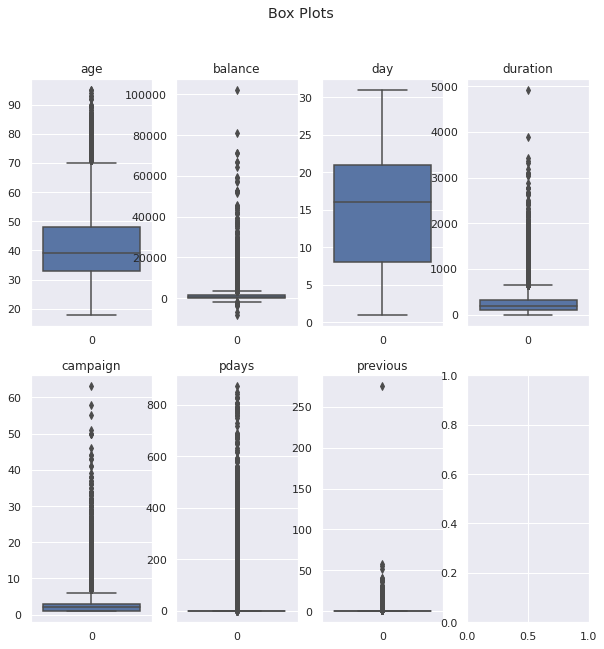

In [12]:
fig, axes = plt.subplots(2,4,figsize=(10,10))
fig.suptitle('Box Plots')

sns.boxplot(ax=axes[0][0], data = df['age'])
sns.boxplot(ax=axes[0][1], data = df['balance'])
sns.boxplot(ax=axes[0][2], data = df['day'])
sns.boxplot(ax=axes[0][3], data = df['duration'])
sns.boxplot(ax=axes[1][0], data = df['campaign'])
sns.boxplot(ax=axes[1][1], data = df['pdays'])
sns.boxplot(ax=axes[1][2], data = df['previous'])

axes[0][0].set_title('age')
axes[0][1].set_title('balance')
axes[0][2].set_title('day')
axes[0][3].set_title('duration')
axes[1][0].set_title('campaign')
axes[1][1].set_title('pdays')
axes[1][2].set_title('previous')

"\naxes[0][0].set_title('job')\naxes[0][1].set_title('marital')\naxes[0][2].set_title('education')\n\naxes[1][0].set_title('default')\naxes[1][1].set_title('housing')\naxes[1][2].set_title('loan')\n\naxes[2][0].set_title('contact')\naxes[2][1].set_title('month')\naxes[2][2].set_title('poutcome')\n"

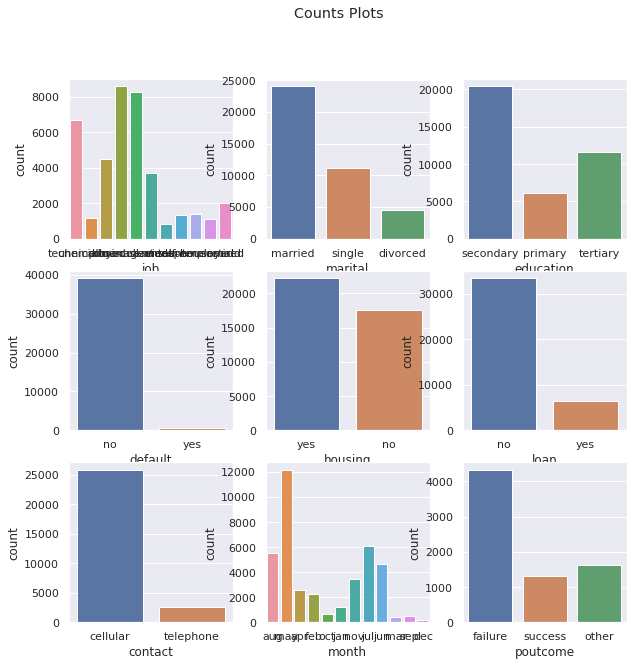

In [13]:
fig, axes = plt.subplots(3,3,figsize=(10,10))
fig.suptitle('Counts Plots')

sns.countplot(ax=axes[0][0], x = df['job'])
sns.countplot(ax=axes[0][1], x = df['marital'])
sns.countplot(ax=axes[0][2], x = df['education'])
sns.countplot(ax=axes[1][0], x = df['default'])
sns.countplot(ax=axes[1][1], x = df['housing'])
sns.countplot(ax=axes[1][2], x = df['loan'])
sns.countplot(ax=axes[2][0], x = df['contact'])
sns.countplot(ax=axes[2][1], x = df['month'])
sns.countplot(ax=axes[2][2], x = df['poutcome'])

"""
axes[0][0].set_title('job')
axes[0][1].set_title('marital')
axes[0][2].set_title('education')

axes[1][0].set_title('default')
axes[1][1].set_title('housing')
axes[1][2].set_title('loan')

axes[2][0].set_title('contact')
axes[2][1].set_title('month')
axes[2][2].set_title('poutcome')
"""


Text(0.5, 1.0, 'previous')

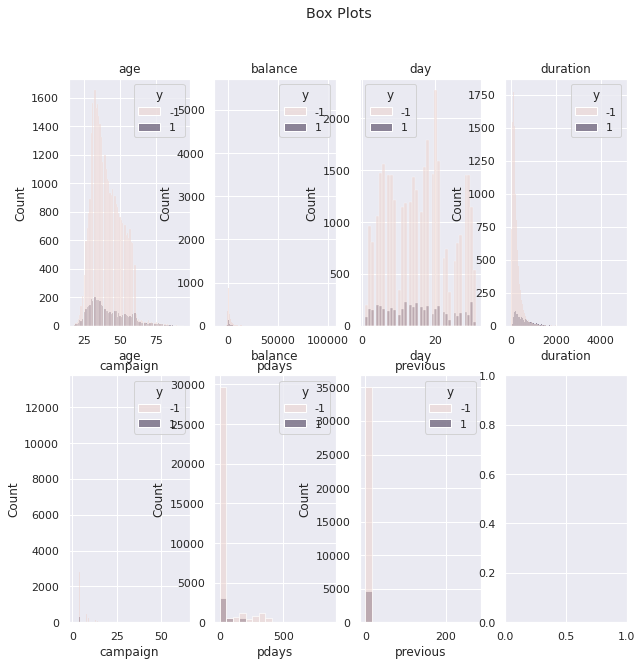

In [14]:
fig, axes = plt.subplots(2,4,figsize=(10,10))
fig.suptitle('Box Plots')

sns.histplot(ax=axes[0][0], data=df, x='age', hue='y')
sns.histplot(ax=axes[0][1], data=df, x='balance', hue='y')
sns.histplot(ax=axes[0][2], data=df, x='day', hue='y')
sns.histplot(ax=axes[0][3], data=df, x='duration', hue='y')
sns.histplot(ax=axes[1][0], data=df, x='campaign', hue='y')
sns.histplot(ax=axes[1][1], data=df, x='pdays', hue='y')
sns.histplot(ax=axes[1][2], data=df, x='previous', hue='y')

axes[0][0].set_title('age')
axes[0][1].set_title('balance')
axes[0][2].set_title('day')
axes[0][3].set_title('duration')
axes[1][0].set_title('campaign')
axes[1][1].set_title('pdays')
axes[1][2].set_title('previous')

<AxesSubplot:xlabel='default', ylabel='Count'>

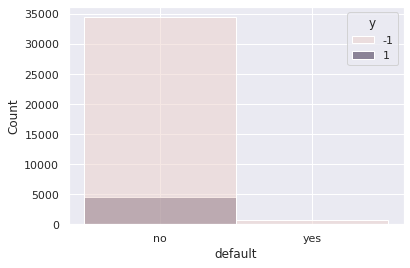

In [15]:
sns.histplot(df, x='default',hue='y')

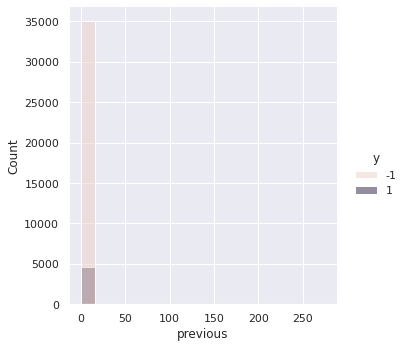

In [16]:
sns.displot(df, x='previous',hue='y')

/home/kiedie/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y', ylabel='count'>

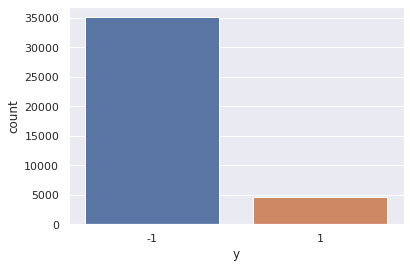

In [17]:
sns.countplot(dftrain.y)

In [18]:
df['default'].value_counts().head()

no     39081
yes      704
Name: default, dtype: int64

# Preprocesado de datos


Eliminar la celda de abajo luego


In [19]:
import numpy as np
import sympy as sp
import sklearn as sk
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import csv

seed = 42


# Leemos etiquetas
df, features = read_data()
# Separamos en test y train
dftrain, dftest = train_test_split(df.copy(), test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True, stratify=df['y'])



In [20]:
# Realizamos copias por si luego necesitamos las originales
dftrain_copy = dftrain.copy()
dftest_copy = dftest.copy()

Vemos la correlación entre los datos numéricos

In [21]:
dftrain.corr()

,age,balance,day,duration,campaign,pdays,previous,y
age,1.000000,0.092663,-0.007772,-0.003618,0.006720,-0.022568,0.000850,0.025468
balance,0.092663,1.000000,0.002606,0.017002,-0.013762,0.001536,0.015243,0.048830
day,-0.007772,0.002606,1.000000,-0.031679,0.162020,-0.094688,-0.048184,-0.030129
duration,-0.003618,0.017002,-0.031679,1.000000,-0.083557,0.000064,0.003116,0.399929
campaign,0.006720,-0.013762,0.162020,-0.083557,1.000000,-0.089995,-0.034625,-0.071925
pdays,-0.022568,0.001536,-0.094688,0.000064,-0.089995,1.000000,0.446303,0.100344
previous,0.000850,0.015243,-0.048184,0.003116,-0.034625,0.446303,1.000000,0.087214
y,0.025468,0.048830,-0.030129,0.399929,-0.071925,0.100344,0.087214,1.000000


/home/kiedie/.local/lib/python3.8/site-packages/seaborn/matrix.py:298: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/home/kiedie/.local/lib/python3.8/site-packages/seaborn/matrix.py:308: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


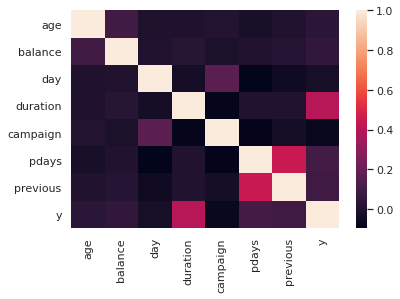

In [22]:
sns.heatmap(dftrain.corr());

## Reducción de Dimensión

Vamos a eliminar el atributo 'poutcome' y para justificarlos nos fijamos en la gran cantidad de valores perdidos que tiene.

In [23]:
print("MissingValues(training[poutcome]) = ", dftrain.isnull().sum()['poutcome'])
# Eliminamos el atributo poutcome por tener demasiado atributos perdidos
dftrain.drop('poutcome', axis=1,inplace=True)
dftest.drop('poutcome', axis=1, inplace=True)

MissingValues(training[poutcome]) =  32510


## Valores perdidos

Vemos los valores perdidos

In [24]:
dftrain.isnull().sum()

age              0
job            268
marital          0
education     1623
default          0
balance          0
housing          0
loan             0
contact      11441
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
y                0
dtype: int64

Vamos a imputar job y education por la moda y vamos a considerar como una nueva categoría los valores perdidos de contact por tener batantes.

In [25]:
# Las variables con valores perdidos son todas caregóricas
ft_missing_v = ['job','education','contact']

Como todos los valores perdidos son categóricos vamos a imputarlos usando la mediana
Primeramente tengo que transformarlos en numéricos para poder realizar el conteo 

In [26]:
input_missing_values(dftrain,dftest,ft_missing_v)

Comprobamos que las modificaciones han sido efectivas

In [27]:
dftrain.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
y            0
dtype: int64

In [28]:
# Vemos que efectivamente hemos añadido un nuevo atributo
dftrain.contact.unique()

array(['cellular', 'telephone', 'new_type'], dtype=object)

## One Hot Encoding

Buscamos las características que son categóricas. La función de abajo nos hace la búsqueda bajo la suposición de que las variables categóricas tienen tipo 'object' en el dataframe

In [29]:
cols_encoder = search_cols_encoders(dftrain)
cols_encoder

{1: 'job',
 2: 'marital',
 3: 'education',
 4: 'default',
 6: 'housing',
 7: 'loan',
 8: 'contact',
 10: 'month'}

Aplicamos One Hot Encoding a las características categóricas

In [30]:
one_hot_encoder_pandas(dftrain,dftest,cols_encoder)

Observamos que hemos hecho efectivos los cambios

In [31]:
dftrain.isnull().sum()

age           0
balance       0
day           0
duration      0
campaign      0
pdays         0
previous      0
y             0
job0          0
job1          0
job2          0
job3          0
job4          0
job5          0
job6          0
job7          0
job8          0
job9          0
job10         0
marital0      0
marital1      0
marital2      0
education0    0
education1    0
education2    0
default0      0
default1      0
housing0      0
housing1      0
loan0         0
loan1         0
contact0      0
contact1      0
contact2      0
month0        0
month1        0
month2        0
month3        0
month4        0
month5        0
month6        0
month7        0
month8        0
month9        0
month10       0
month11       0
dtype: int64

## Normalización

Buscamos las características numéricas.

In [32]:
numeric_features = search_numeric_ft(dftrain)
numeric_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Normalizamos

In [33]:
mean, std = normalizar_zscore(dftrain,dftest,numeric_features)

## Eliminación de outliers

Vamos a proceder a la eliminación de outlierse. Usamos un método que se vaya en distancias para localizarlos y es sensible a tamaño de escala. Por ese motivo previamente necesitamos los datos normalizados. Cuando eliminemos los outliers, deshacemos el normalizado y volvemos a normalizar sin tener en cuenta ya los outliers.

In [34]:
from sklearn.neighbors import LocalOutlierFactor

# Atributos que tienen outliers
outliers_ft = ['age','balance','duration','campaign','pdays','previous']

# Eliminamos los outliers 
index, index_no, index_yes = remove_outliers(dftrain,outliers_ft, show=True)

# Desnormalizamos
desnormalizar(dftrain,dftest,numeric_features, mean, std)
# Volvemos a normalizar con las características del nuevo conjunto sin outliers
mean, std = normalizar_zscore(dftrain,dftest,numeric_features)

========== Outliers: age ==========
Counter({1: 39753, -1: 32})
========== Outliers: balance ==========
Counter({1: 38315, -1: 1470})
========== Outliers: duration ==========
Counter({1: 39335, -1: 450})
========== Outliers: campaign ==========
Counter({1: 39743, -1: 42})
========== Outliers: pdays ==========
Counter({1: 39259, -1: 526})
========== Outliers: previous ==========
Counter({1: 39762, -1: 23})
Index.shape =  (2476,)
Index_no.shape =  (2151,)
Index_yes.shape =  (325,)
========== Antes ==========
Etiquetas Counter({-1: 35137, 1: 4648})
========== Despues ==========
Etiquetas Counter({-1: 32986, 1: 4648})


## Mutal info

In [35]:
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold

In [36]:
# Obtenemos etiquetas
y_train = dftrain.y.to_numpy().copy()
y_test  = dftest.y.to_numpy().copy()

# Eliminamos las etiquetas de la matriz
dftrain.drop('y',axis=1,inplace=True)
dftest.drop('y',axis=1,inplace=True)

# Pasamos la matriz a numpy
X_train = dftrain.to_numpy().copy()
X_test = dftest.to_numpy().copy()

In [37]:
dep, best = dependencia(X_train,y_train,umbral=0.01)

In [38]:
dep

[(0, 0.012321856321662272),
 (1, 0.023832950629487648),
 (2, 0.009638997805091476),
 (3, 0.08140779980962343),
 (4, 0.0051174145253449765),
 (5, 0.029824831936731577),
 (6, 0.01672319298927416),
 (7, 0.0006973015851383657),
 (8, 0.002225395953379339),
 (9, 0.0017317829333018953),
 (10, 0.001116519935229654),
 (11, 0.0006761990553918462),
 (12, 0.002017847954350449),
 (13, 0.0004155801001310966),
 (14, 0.0005530256288766022),
 (15, 0.0033114960898312784),
 (16, 0.0010444428689826424),
 (17, 0.001084015529634108),
 (18, 0.0),
 (19, 0.003455502012339462),
 (20, 0.003369665971140634),
 (21, 0.0),
 (22, 0.00305453968048619),
 (23, 0.0013311901387953462),
 (24, 0.002332810272277719),
 (25, 0.0),
 (26, 0.010703148335953427),
 (27, 0.01141809460714982),
 (28, 0.00590861956433586),
 (29, 0.004298183819092305),
 (30, 0.014747012449467745),
 (31, 0.016182617350223083),
 (32, 0.0023786707483601788),
 (33, 0.0006022794123676789),
 (34, 0.0),
 (35, 0.0005794337434423813),
 (36, 0.0019205326122868627

In [39]:
best

array([ 0,  1,  3,  5,  6, 26, 27, 30, 31])

## Numero de Elementos de cada clase en cada conjunto

In [40]:
Counter(y_train)

Counter({-1: 32986, 1: 4648})

In [41]:
Counter(y_test)

Counter({-1: 8785, 1: 1162})

In [42]:
y_test.shape

(9947,)

In [43]:
dfval = train_test_split(X_train,y_train, test_size = 0.1, train_size= 0.9, random_state=seed, shuffle=True, stratify=y_train)

In [44]:
Counter(dfval[2])

Counter({1: 4183, -1: 29687})

In [45]:
dfval[2].shape

(33870,)

## PCA y t-SNE

<ipython-input-2-4b68e90d7ae5>:461: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


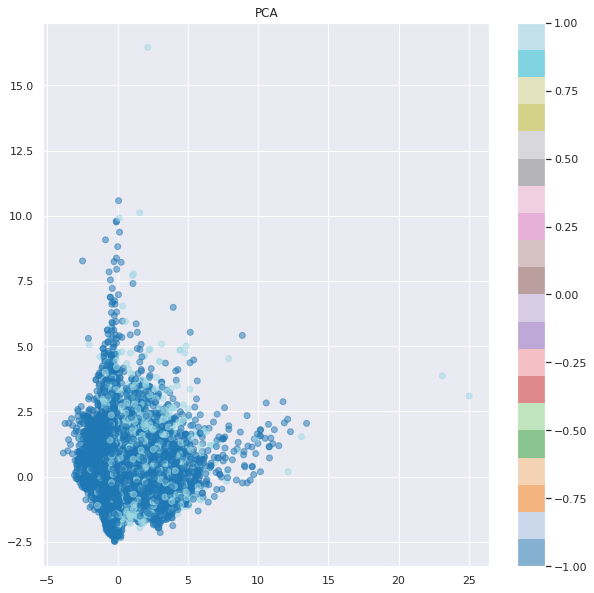

<ipython-input-2-4b68e90d7ae5>:461: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


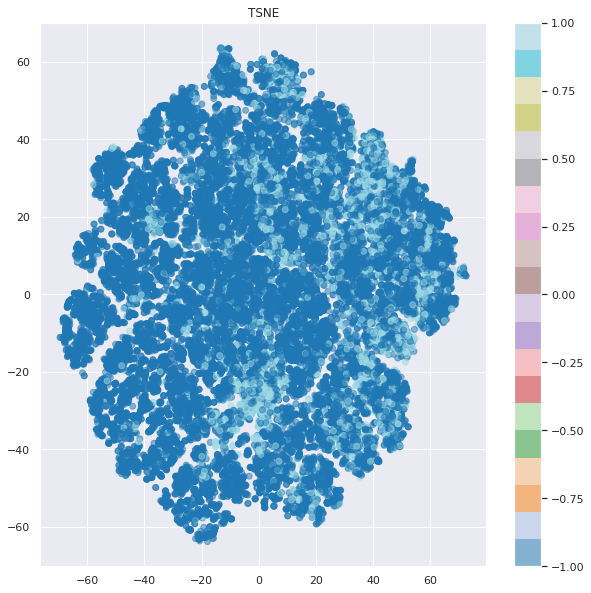

In [46]:
pca=PCA(n_components=2, random_state=1)
x_pca=pca.fit_transform(X_train)

#Visualizamos los datos resultantes en 2D
plot2D(x_pca, y_train, 'PCA')

x_tsne = TSNE(n_components=2, init=x_pca, perplexity=50).fit_transform(X_train)

#Visualizamos los datos resultantes en 2D
plot2D(x_tsne, y_train, 'TSNE')

# Modelos 
Este apartado tarda bastante

Leemos datos y aplicamos preprocesado

In [4]:
# Leemos etiquetas
df, features = read_data()
# Separamos en test y train
dftrain, dftest = train_test_split(df.copy(), test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True, stratify=df['y'])
X_train, y_train, X_test, y_test = preprocesado(dftrain,dftest)

Calculamos polinomios de grado 1, 2 y 3.
- X_train1 - polinomios grado 1
- X_train2 - polinomios grado 2
- X_train3 - polinomios grado 3

In [5]:
# Instanciamos las tansformaciones polinomiales
NLT2 = PolynomialFeatures(2,include_bias=False)
# Hacemos una copia de los conjuntos de datos de entrenamiento
X_train1 = X_train.copy()
X_train2 = X_train.copy()
# Entrenamos las funciones parahacer la transformacion
NLT2.fit(X_train2)
# Aplicamos transformacion
X_train2 = NLT2.transform(X_train2)
# Ahora lo hacemos con los datos de test
X_test1 = X_test.copy()
X_test2 = X_test.copy()
X_test2 = NLT2.transform(X_test2)

## PLA, PLA Pocket

In [49]:
parameters = {'penalty' : ['l1','l2'], 'alpha'   : [0.0001, 0.001], 'early_stopping' : [False,True]}

parameters2 = {'penalty' : ['l1','l2'],'alpha'   : [0.0001, 0.001]}

pol1 = apply_grid(Perceptron(max_iter = 100000, tol = 0.0000001, shuffle = True, random_state = seed,n_iter_no_change=1000), parameters,X_train1,y_train,show=True, mensaje = 'Pol grado 1')
#pol1.to_csv('plapol1.csv')
pol2 = apply_grid(Perceptron(max_iter = 100000, tol = 0.0000001, shuffle = True, random_state = seed,n_iter_no_change=500) ,parameters2,X_train2,y_train,show=True, mensaje = 'Pol grado 2')
#pol2.to_csv('plapol2.csv')

Pol grado 1
Best Score:  0.4639715015523101
Best Params:  {'alpha': 0.0001, 'early_stopping': True, 'penalty': 'l1'}
Pol grado 2
Best Score:  0.45425561202425896
Best Params:  {'alpha': 0.0001, 'penalty': 'l1'}


## Regresión Logística

In [ ]:
parameters = {'C' : [0.1,1,10] , 'solver': ['newton-cg','lbfgs','liblinear','sag','saga']}

lr  = LogisticRegression(penalty ='l2', multi_class = 'ovr',random_state=seed, max_iter = 5000, tol = 0.0001)
lr2 = LogisticRegression(penalty ='l2', multi_class = 'ovr',random_state=seed, max_iter = 5000, tol = 0.0001)
lr3 = LogisticRegression(penalty ='l2', multi_class = 'ovr',random_state=seed, max_iter = 5000, tol = 0.0001)

lrp1 = apply_grid(lr, parameters,X_train, y_train,scoring='f1',show=True, mensaje = 'Pol grado 1')
#lrp1.to_csv('lrp1.csv')
lrp2 = apply_grid(lr2,parameters,X_train2,y_train,scoring='f1',show=True, mensaje = 'Pol grado 2')
#lrp2.to_csv('lrp2.csv')



## SVM

In [ ]:
parameters = {'C':np.logspace(-4,4,5)}

svc1 = LinearSVC(penalty='l2',loss = 'squared_hinge',dual=False,max_iter=1000,tol=0.0001,multi_class='ovr')
svc2 = LinearSVC(penalty='l2',loss = 'squared_hinge',dual=False,max_iter=1000,tol=0.0001,multi_class='ovr')
svc3 = LinearSVC(penalty='l2',loss = 'squared_hinge',dual=False,max_iter=1000,tol=0.0001,multi_class='ovr')

svcp1 = apply_grid(svc1, parameters,X_train1, y_train,scoring='f1',show=True, mensaje = 'Pol grado 1')
#svcp1.to_csv('svcp1.csv')
svcp2 = apply_grid(svc2, parameters,X_train2, y_train,scoring='f1',show=True, mensaje = 'Pol grado 2')
#svcp2.to_csv('svcp2.csv')

# Modelos Ganadores
Declaramos los modelos ganadores

In [6]:
g_svc1 = LinearSVC(penalty='l2',loss = 'squared_hinge',C=10000,dual=False,max_iter=1000,tol=0.0001,multi_class='ovr')
g_svc2 = LinearSVC(penalty='l2',loss = 'squared_hinge',C=1,dual=False,max_iter=1000,tol=0.0001,multi_class='ovr')

g_pla1 = Perceptron(penalty='l1',max_iter = 100000,alpha=0.001,early_stopping=False, tol = 0.0000001, shuffle = True, random_state = seed,n_iter_no_change=1000)
g_pla2 = Perceptron(penalty='l1',alpha=0.0001,max_iter = 100000, tol = 0.0000001, shuffle = True,early_stopping=False ,random_state = seed,n_iter_no_change=1000)

g_lr = LogisticRegression(penalty ='l2', solver='lbfgs',C=10, multi_class = 'ovr',random_state=seed, max_iter = 5000, tol = 0.0001)

Ahora entrenamos los modelos con los datos de entrenamiento y evaluarmos con los datos de test

In [52]:
modelos1     = [g_svc1,g_pla1,g_lr]
str_modelos1 = ['SVC_1','PLA_1','LR']
modelos2     = [g_svc2,g_pla2]
str_modelos2 = ['SVC_2','PLA_2'] 

for i,model in enumerate(modelos1):
    get_final_results(model,X_train,y_train,X_test,y_test,name_modelo=f'-----{str_modelos1[i]}-----',show=True)

for i,model in enumerate(modelos2):
    get_final_results(model,X_train2,y_train,X_test2,y_test,name_modelo=f'-----{str_modelos2[i]}-----',show=True)    

-----SVC_1-----
F1 en el conjunto de entranamiento:  0.36678944137507674
F1 en el conjunto de test:  0.35064141722663406
-----PLA_1-----
F1 en el conjunto de entranamiento:  0.313519342229411
F1 en el conjunto de test:  0.28651973347001536
-----LR-----
F1 en el conjunto de entranamiento:  0.41935483870967744
F1 en el conjunto de test:  0.3979298447383554
-----SVC_2-----
F1 en el conjunto de entranamiento:  0.5454310789881259
F1 en el conjunto de test:  0.49585921325051757
-----PLA_2-----
F1 en el conjunto de entranamiento:  0.5195717631314821
F1 en el conjunto de test:  0.5006510416666666


# Curvas de aprendizaje

## SVC

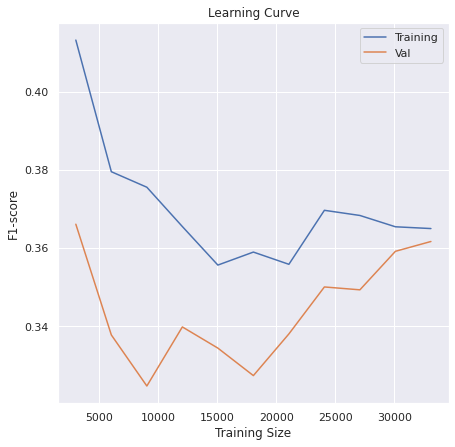

In [53]:
plot_learning_curve(X_train1,y_train,percentage=0.1,modelo = g_svc1,metrica = f1_score,modelo_str=None,metrica_str = 'F1-score',stratify = True, figsize = (7,7))

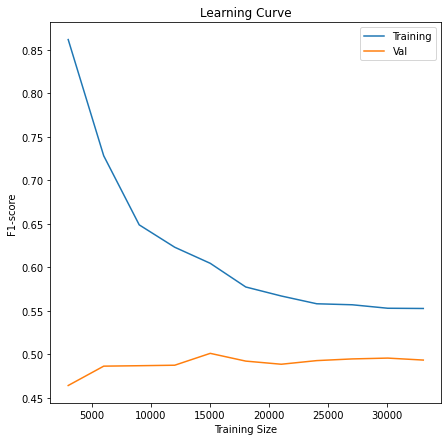

In [7]:
plot_learning_curve(X_train2,y_train,percentage=0.1,modelo = g_svc2,metrica = f1_score,modelo_str=None,metrica_str = 'F1-score',stratify = True, figsize = (7,7))

## PLA

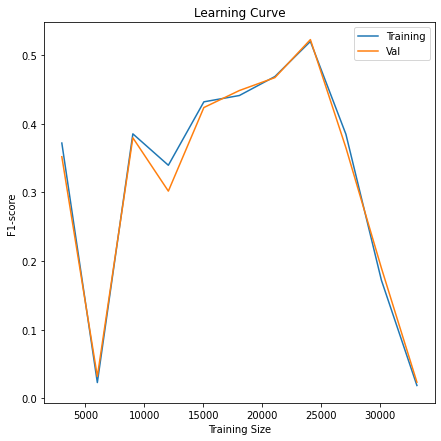

In [8]:
plot_learning_curve(X_train1,y_train,percentage=0.1,modelo = g_pla1,metrica = f1_score,modelo_str=None,metrica_str = 'F1-score',stratify = True, figsize = (7,7))

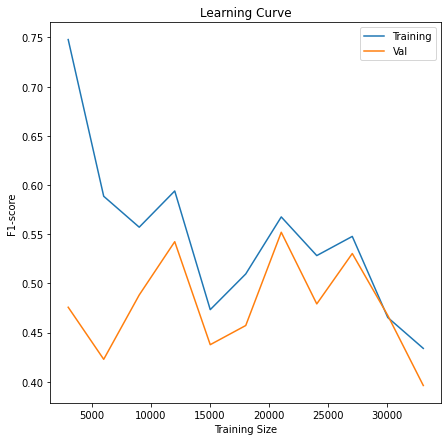

In [9]:
plot_learning_curve(X_train2,y_train,percentage=0.1,modelo = g_pla2,metrica = f1_score,modelo_str=None,metrica_str = 'F1-score',stratify = True, figsize = (7,7))

## LR

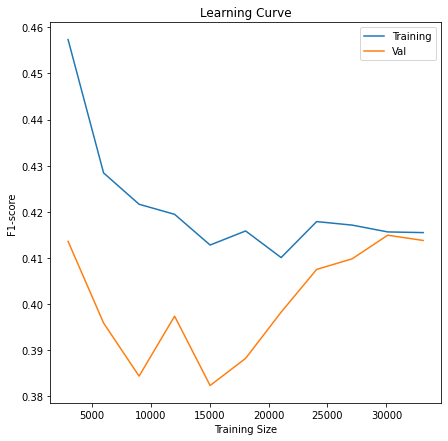

In [10]:
plot_learning_curve(X_train1,y_train,percentage=0.1,modelo = g_lr,metrica = f1_score,modelo_str=None,metrica_str = 'F1-score',stratify = True, figsize = (7,7))

# Matrices de Confusión

In [ ]:
from sklearn.metrics import plot_confusion_matrix

g_svc2.fit(X_train2,y_train)
plot_confusion_matrix(g_svc2,X_test2,y_test)


# Entrenamos con todos los datos

Tomamos el modelo ganador y lo entrenamos con todos los datos

In [11]:
# Leemos etiquetas
df, features = read_data()
# Preprocesamos sin tener en cuenta el conjunto de test
X_train, y_train = preprocesado(df,training_only=True)
# Hacemos la transformacion polinomial
NLT2 = PolynomialFeatures(2,include_bias=False)
X_train = NLT2.fit_transform(X_train)

In [12]:
# Declaramos el modelo ganador
winner = LinearSVC(penalty='l2',loss = 'squared_hinge',C=1,dual=False,max_iter=1000,tol=0.0001,multi_class='ovr')
# Barajamos el conjunto de datos
X_train, y_train = shuffle(X_train,y_train,random_state=seed)
# Aplicamos 
winner.fit(X_train,y_train)
ypred = winner.predict(X_train)
f1_score(y_train,ypred)

0.5373506493506492

In [13]:
# Declaramos el modelo ganador
winner = LinearSVC(penalty='l2',loss = 'squared_hinge',C=1,dual=False,max_iter=1000,tol=0.0001,multi_class='ovr')
# Barajamos el conjunto de datos
X_train, y_train = shuffle(X_train,y_train,random_state=seed)
# Aplicamos Cross Validation
E_val = cross_val_score(winner, X_train, y=y_train,scoring='f1', cv=5, n_jobs=-1, verbose=0)

In [14]:
E_val.mean()

0.5039187009964421